In [1]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam
from backtester.swarms import SwarmManager, SwarmRanker
from backtester.positionsizing import PositionSizingBase
import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
strategyname_global = 'strategy_270225'
d, info = matlab.loaddata('../mat/'+strategyname_global+'.mat')

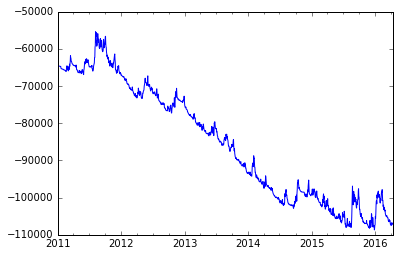

In [4]:
d.exo.plot()


In [5]:
info

{'legs': 4,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

# Class based strategy

* Enter short when fast MA crosses down slow MA
* Exit when fast MA crosses up slow MA + median trailing stop


In [6]:
class StrategyMACrossTrail(StrategyBase):
    def __init__(self):
        # Initialize parent class
        super().__init__()
        
        # Define system's name
        self.name = 'MA Crossing with trailing stop'
        
        # This is a short strategy
        self.direction = -1
        
        # Define optimized params
        self.opts = [
            #OptParam(name, default_value, min_value, max_value, step)
            OptParam('SlowMAPeriod', 20, 10, 30, 2),
            OptParam('FastMAPeriod', 2, 2, 20, 1),
            OptParam('MedianPeriod', 5, 5, 20, 3)
        ]
        
        self.initialize()
        
    def initialize(self):
        #
        #  Loading EXO quotes from .mat file
        #
        strategyname = strategyname_global
        self.data, info = matlab.loaddata('../mat/'+strategyname+'.mat')
        
        #
        # Estimating transaction costs in base points of price
        #
        
        # No costs
        self.costs = pd.Series(0, self.data.index)
        
        # Flat costs / 1 point of EXO price per side / 2 roundtrip
        #self.costs = pd.Series(1, self.data.index)
        
        # Dynamic costs (we could utilize dynamic costs models)
        #  Like slippage calculation on bid/ask data / etc
        # Some meta code (just in my imagination)
        # costmanager = CostManager('EXO.Ticker').LoadSlippageFromDB('2000-01-01', now)
        # self.costs = costmanager.getslippage() + pd.Series(0.1, self.data.index) # Slippage + commission
    
    @property
    def positionsize(self):
        """
        Returns volatility adjuster positions size for strategy
        :return:
        """
        # Defining EXO price
        px = self.data.exo

        # Calculate position size adjusted to volatility of EXO
        # Dollar risk per 1 volatility unit
        risk_perunit = 100
        risk_vola_period = 100

        # Calculate volatility unit
        # In this case we use 10-period rolling median of EXO changes
        vola = abs(px.diff()).rolling(risk_vola_period).median()
        # We want to risk 100$ per 1 volatility unit
        #
        # This type of position sizing used for calibration of swarm members
        # After swarm generation and picking we will use portfolio based MM by Van Tharp
        # Tailored for portfolio size and risks of particular client
        return risk_perunit / vola
    
    def calculate(self, params=None):
        #        
        #
        #  Params is a tripple like (50, 10, 15), where:
        #   50 - slow MA period
        #   10 - fast MA period
        #   15 - median period
        #
        #  On every iteration of swarming algorithm, parameter set will be different.
        #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
        #       
        
        if params is None:
            # Return default parameters
            period_slow, period_fast, period_median = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            period_slow, period_fast, period_median = params
        
        # Defining EXO price
        px = self.data.exo
        
        #
        #
        # Indicator calculation
        #
        #
        slow_ma = px.rolling(period_slow).mean()
        fast_ma = px.rolling(period_fast).mean()
        # Median based trailing stop
        trailing_stop = px.rolling(period_median).median().shift(1)        
    
        # Enry/exit rules
        entry_rule = CrossDown(fast_ma, slow_ma)
        exit_rule = (CrossUp(fast_ma, slow_ma) ) | (CrossUp(px, trailing_stop))
        
        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness 
        swarm_member_name = str((period_slow, period_fast, period_median))        
        
        return swarm_member_name, entry_rule, exit_rule
        

<h1>Backtest results</h2>

In [7]:
# Initiate the strategy

strategy = StrategyMACrossTrail()

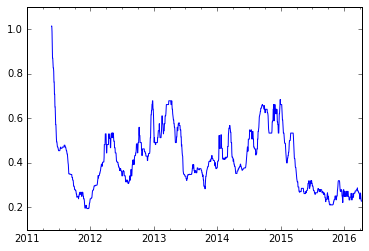

In [8]:
strategy.positionsize.plot()

In [11]:
# Running all parameters permutations in swarm
swarm, swarm_stats, swarm_inposition = strategy.run_swarm()

In [12]:
# Saving swarm for future use
swarm.to_hdf('../swarms/macross_trailing.h5', 'swarm')

# Analyze the swarm

In [ ]:
swarm = pd.read_hdf('../swarms/macross_trailing.h5', 'swarm')

### Exploriong swarm bounds

In [ ]:
figsize(15,10)
title(strategy.name)
swarm.apply(lambda x: np.percentile(x, q=95), axis=1).plot(label='Top 5%', c='g')
swarm.apply(lambda x: np.percentile(x, q=66), axis=1).plot(label='Top 66%', c='g', style='k--')
swarm.apply(np.median, axis=1).plot(label='Median member')
swarm.apply(lambda x: np.percentile(x, q=33), axis=1).plot(label='Bottom 33%', c='r', style='k--')
swarm.apply(lambda x: np.percentile(x, q=5), axis=1).plot(label='Bottom 5%', c='r')

legend(loc=2);

## Picking the swarm members and compose a portfolio


In [ ]:
# Swarm Manager context (settings)
context = {
    'nsystems': 5, # Number of swarm members to pick
}

# Rebalance the swarm every Monday
rebalance_time = swarm.index.dayofweek == 0
# We can use smart rebalancing logics (like event driven logics)
# rebalance_time = (5 days before contracts expiration)
# rebalance_time = (rebalance if something changed in EXO behavior)
# rebalance_time = (picked systems has shown degradation)


#
# Swarm ranking algorithm setup
#

# Rank systems by 14 days returns of equity
# FYI: ranking_func must me assigned without () at the end of line!
ranking_func =  SwarmRanker.highestreturns_14days
# ranking_func = (any ranking logics we want!)
# ranfing_func = (pick members with the best sharpe ratio)
# ranfing_func = (pick most stable members all time)
# ranfing_func = (pick most profitables members, which is currently in drawdown)


### Setting up SwarmManager

In [ ]:
swarm_manager = SwarmManager(rebalancetime=rebalance_time,    # Every week
                             rankerfunc=ranking_func,         # Rank - 14 days returns
                             context=context,                 # Backtester settings / params
                            )

In [ ]:
# Getting average swarm member equity
avg_swarm = SwarmManager.get_average_swarm(swarm)

### Swarm global filtering algorithms



In [245]:
#
# We can analyse avg_swarm equity or apply EXO based logics, everything we want
#

global_filter = None

# Simple logic: trade if avg_swarm equity greater then moving_average(100)
global_filter = avg_swarm < avg_swarm.rolling(100).mean()

# For example
# global_filter = (swing point global filter)
# global_filter = (global volatility index (like VIX, for each asset) filter)


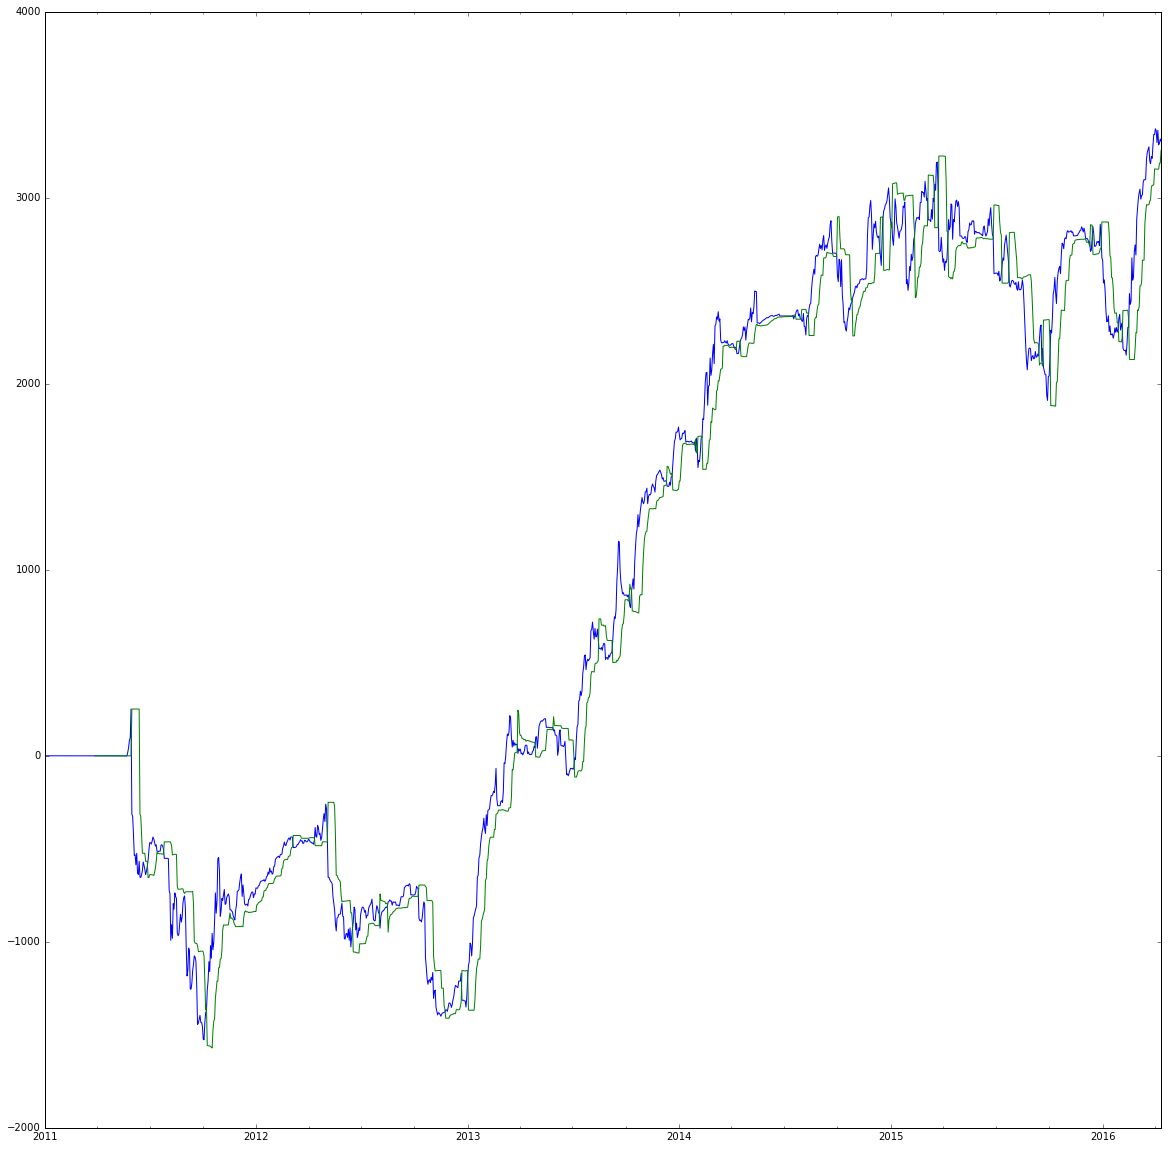

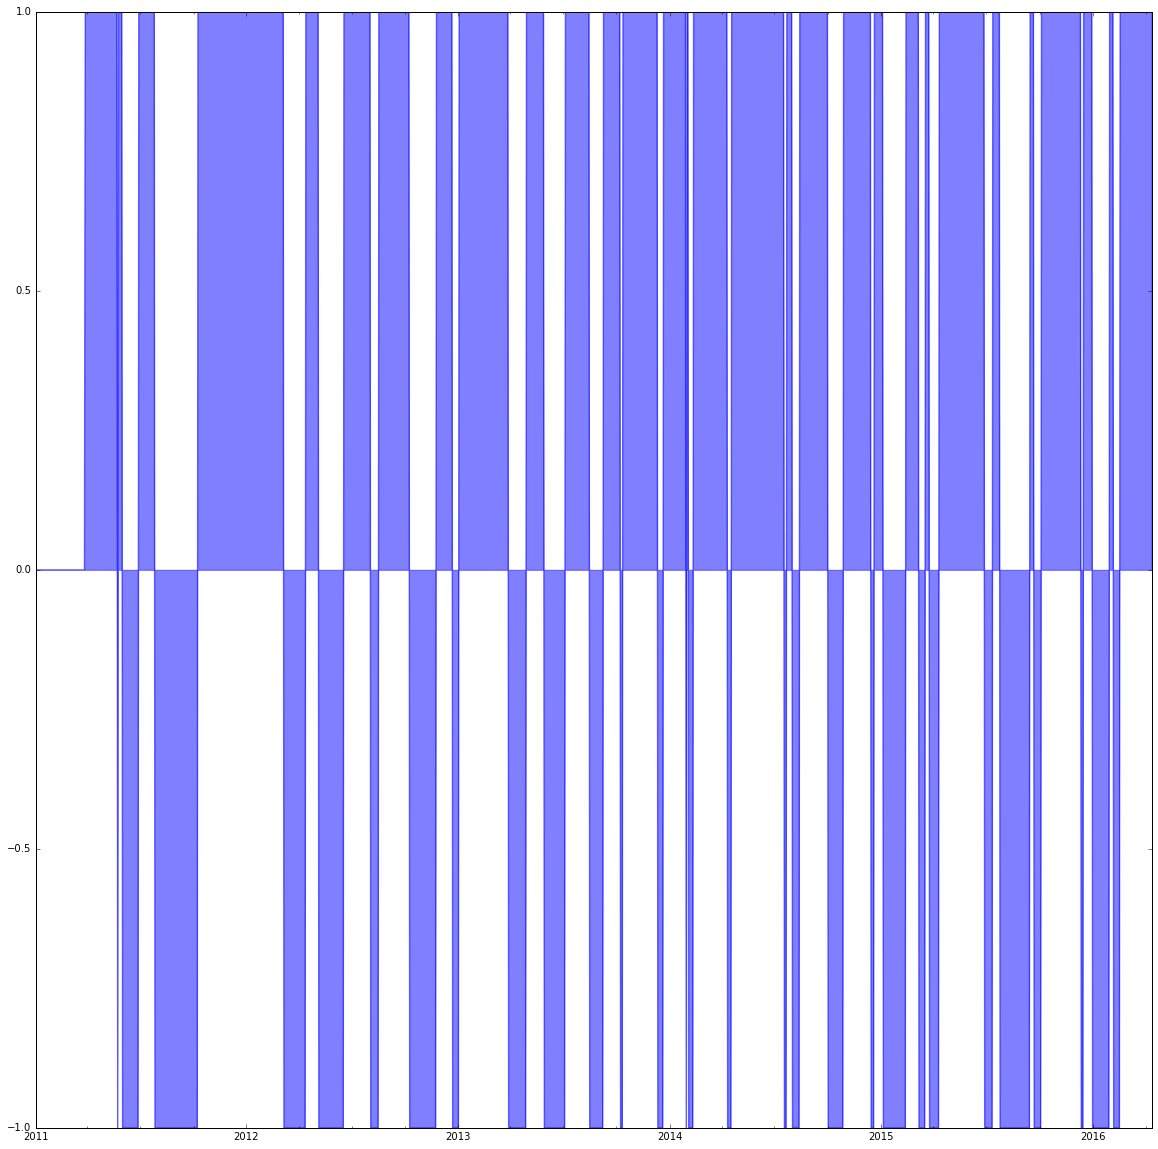

In [404]:
price = avg_swarm #.ix['2015-06':]
period = 10
vola_offset = 1.0
 
def swingpoint_filter(price, period, offset_factor):
    #
    # Using Hi/Lo offret as a factor of volatility
    #
    offset = price.diff().abs().rolling(60).median()
    hhv = price.rolling(period).max().shift() + offset_factor*offset
    llv = price.rolling(period).min().shift() - offset_factor*offset
    swing_point = pd.Series(np.nan, index=price.index)
    swing_point_regime = pd.Series(0, index=price.index)
    swing_switch = 0
    for i in range(len(price)):
        if price.values[i] >= hhv.values[i]:
            swing_switch = 1
        elif price.values[i] <= llv.values[i]:
            swing_switch = -1
        if swing_switch == 1:
            swing_point.values[i] = llv.values[i]
            swing_point_regime.values[i] = swing_switch
        elif swing_switch == -1:
            swing_point.values[i] = hhv.values[i]
            swing_point_regime.values[i] = swing_switch
    
    return swing_point, swing_point_regime
    
swing_point, swing_point_regime = swingpoint_filter(price, period, vola_offset)

price.plot()
swing_point.plot()
figure()

swing_point_regime.plot.area(stacked=False)


In [412]:
pd.Series((swing_point_regime != swing_point_regime.shift()), dtype=np.int32).sum()

60

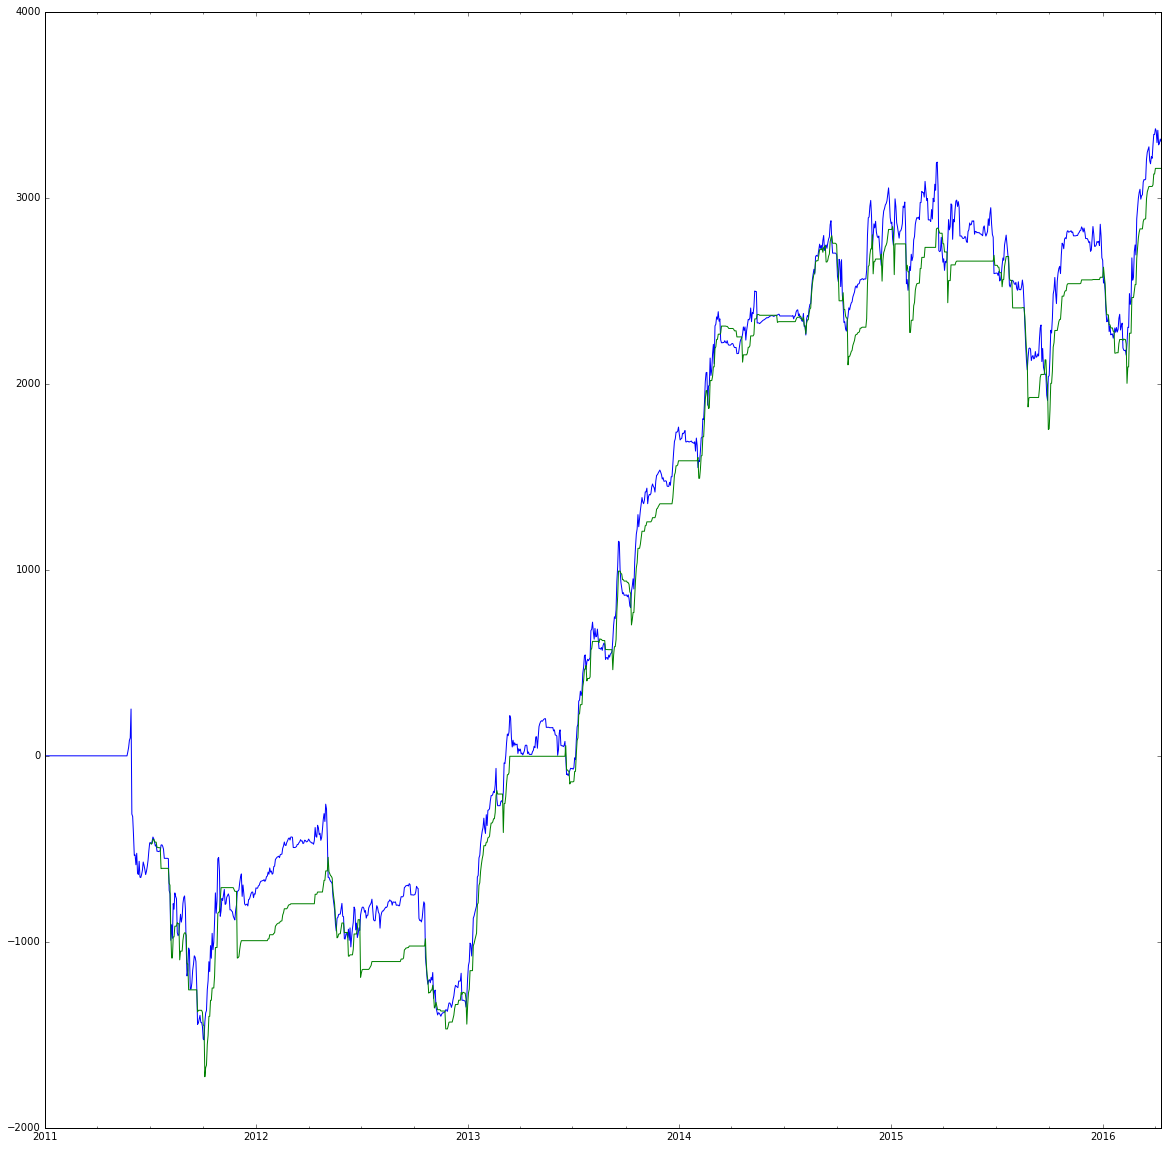

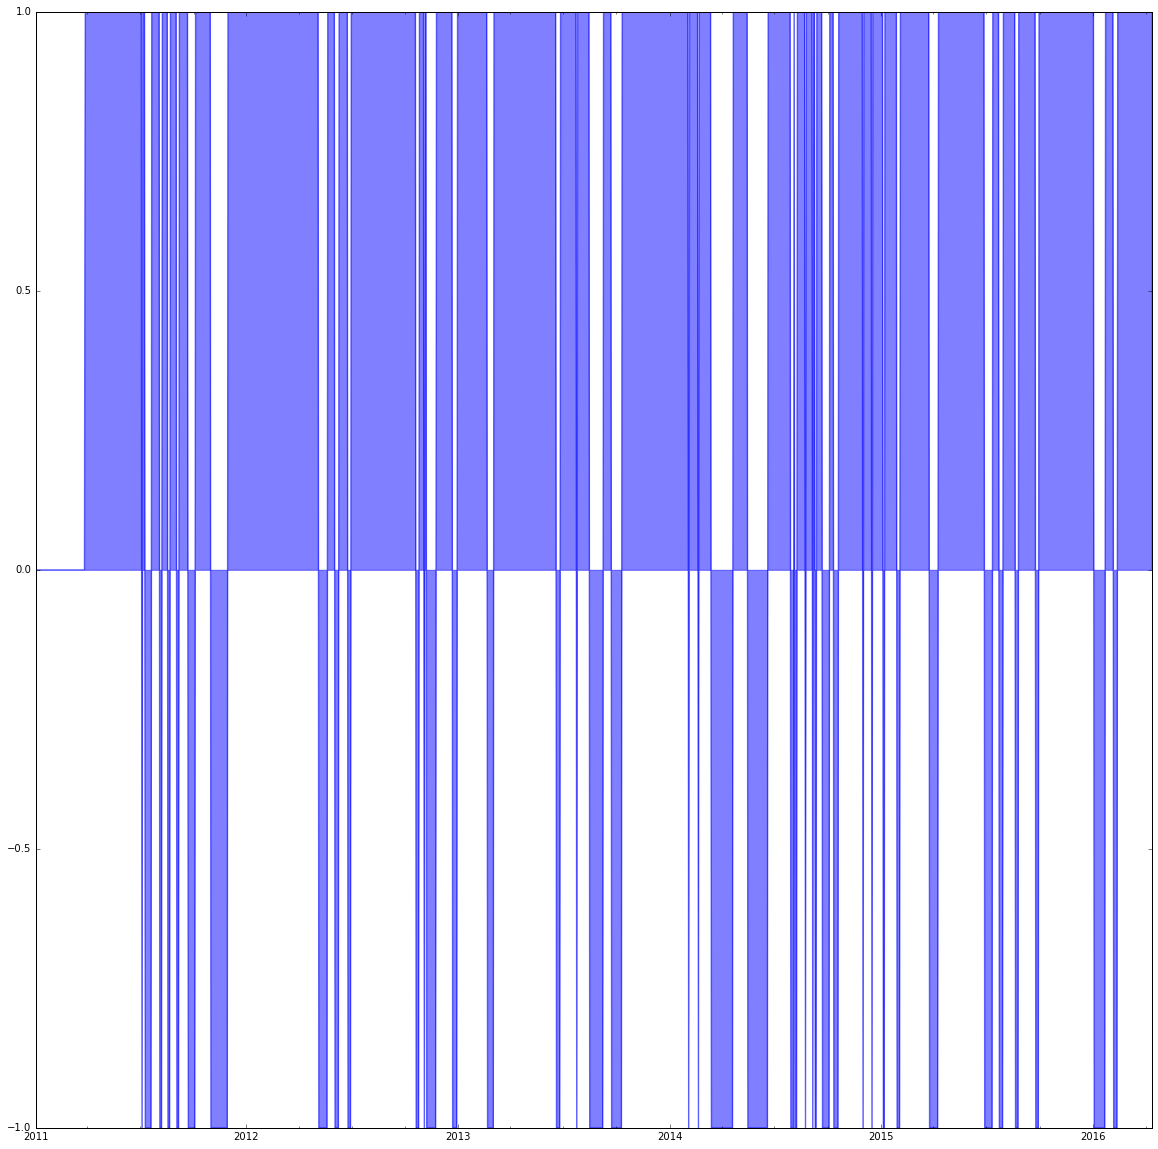

In [405]:
up_factor = 3.0
down_factor = 10.0

def swingpoint_filter_threshold(price, period, up_factor, down_factor):
    vola = price.diff().abs().rolling(60).median()
    
    
    swing_point = pd.Series(np.nan, index=price.index)
    swing_point_regime = pd.Series(0, index=price.index)
    
    # Swing point bullish regime
    swing_switch = 1
    
    # Swing point start index
    sw_i = -1
    
    # Min/Max prices for swings
    sw_h_max = price[0]
    sw_l_min = price[0]
    
    
    for i in range(len(price)):
        if i == 0:
            continue
        if np.isnan(price[i]):
            continue
        if np.isnan(vola.values[i]):            
            continue
        elif sw_i == -1 and vola.values[i] > 0:     
            sw_h_max = sw_l_min = price[i]
            sw_i = i
        
        
        if swing_switch == 1:
            #
            #  We have a bullish swing 
            #
            sw_h_max = max(sw_h_max, price[i])
            
            
            # Check for reversion
            if price[i] <= sw_h_max-vola[sw_i]*down_factor:
                # Reverse swing
                swing_switch = -1
                sw_l_min = price.values[i]
                sw_h_max = price.values[i]
                swing_point.values[i] = sw_l_min + vola[sw_i]*up_factor
                
                sw_i = i
            else:
                swing_point.values[i] = sw_h_max-vola[sw_i]*down_factor  
                
                
        else:
            #
            #  We have a bearish swing
            #
            sw_l_min = min(sw_l_min, price.values[i])
            
            
            # Check for reversion
            if price.values[i] >= sw_l_min + vola[sw_i]*up_factor:
                # Reverse swing
                swing_switch = 1
                sw_l_min = price.values[i]
                sw_h_max = price.values[i]
                sw_i = i
                swing_point.values[i] = sw_h_max - vola[sw_i]*down_factor                  
            else:
                swing_point.values[i] = sw_l_min + vola[sw_i]*up_factor  
                
        swing_point_regime.values[i] = swing_switch                
    return swing_point, swing_point_regime
            
            
swing_point_threshold, swing_point_regime_threshold = swingpoint_filter_threshold(price, period, up_factor, down_factor)

price.plot()
swing_point_threshold.plot()
figure()

swing_point_regime_threshold.plot.area(stacked=False)    
    

### Applying global swingpoint factor

In [406]:
# Simple swing point filter
#global_filter = swing_point_regime == -1


# Swing point filter with volatility threshold
global_filter = swing_point_regime_threshold == -1



### Comparing of swarms w/without global filter

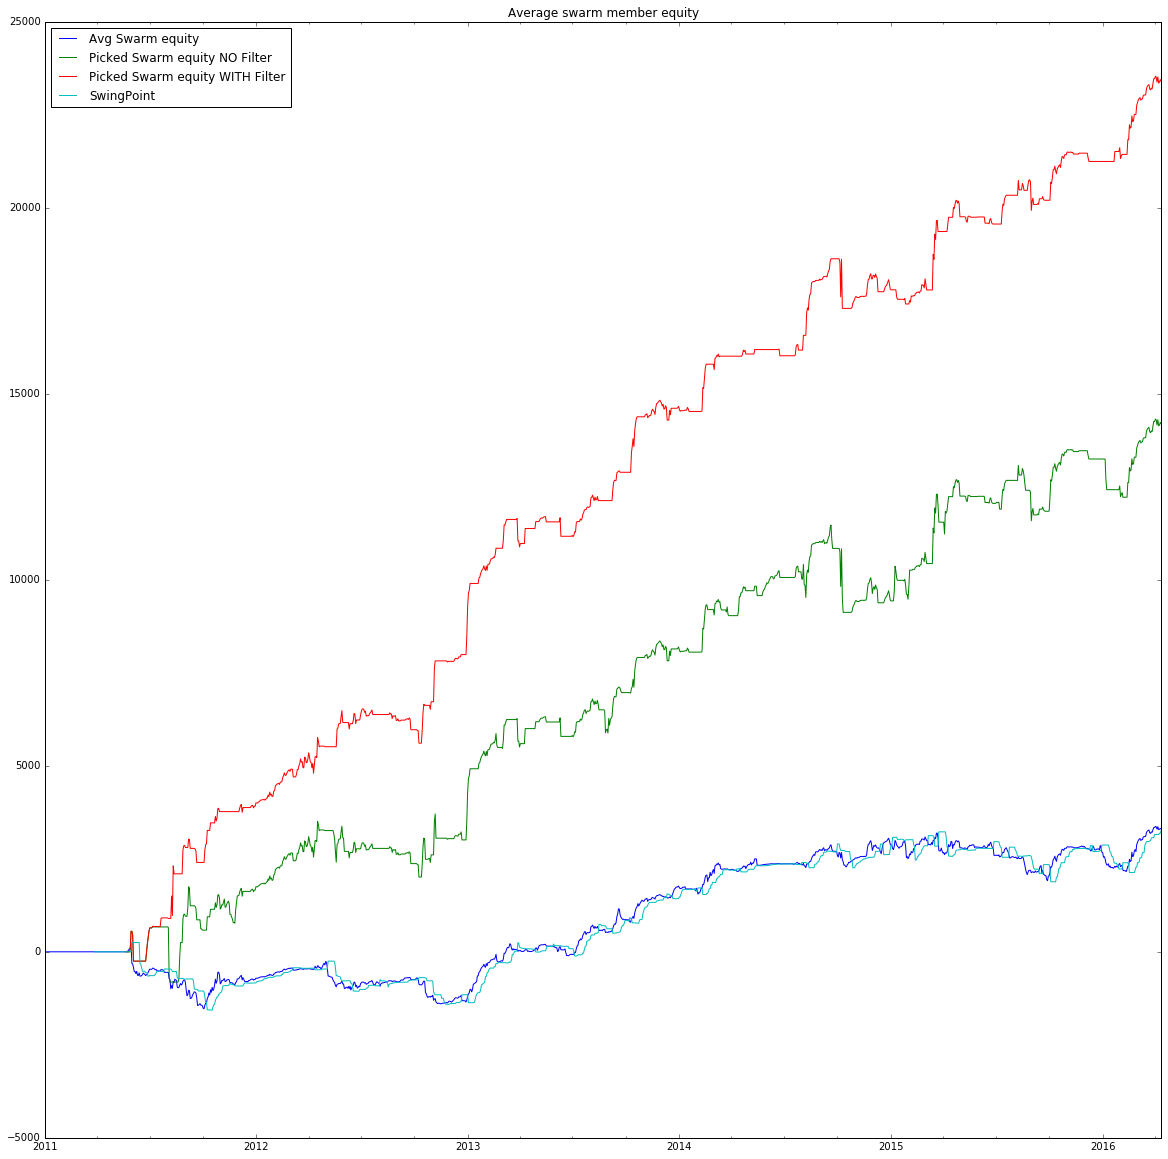

In [407]:
eq_changes = swarm.diff()

figsize(20, 20)
is_picked_df_no_filter = swarm_manager.backtest(swarm)
is_picked_df_with_filter = swarm_manager.backtest(swarm, global_filter)

avg_picked_equity_no_filter = eq_changes[is_picked_df_no_filter == 1.0].mean(axis=1).cumsum().ffill()
avg_picked_equity_with_filter = eq_changes[is_picked_df_with_filter == 1.0].mean(axis=1).cumsum().ffill()

avg_all_equity = avg_swarm


avg_all_equity.plot(label='Avg Swarm equity');
avg_picked_equity_no_filter.plot(label='Picked Swarm equity NO Filter')
avg_picked_equity_with_filter.plot(label='Picked Swarm equity WITH Filter')
#avg_swarm.rolling(100).mean().plot(label='Avg Swarm MovingAvg filter')
swing_point.plot(label='SwingPoint')
title('Average swarm member equity');
legend(loc=2)

In [417]:
reb_df = pd.DataFrame( is_picked_df_with_filter != is_picked_df_with_filter.shift(), dtype=np.int32).sum()


In [421]:
reb_df.order(ascending=False).to_csv('MACross_Swarm_Rebalancing_stats.csv')

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


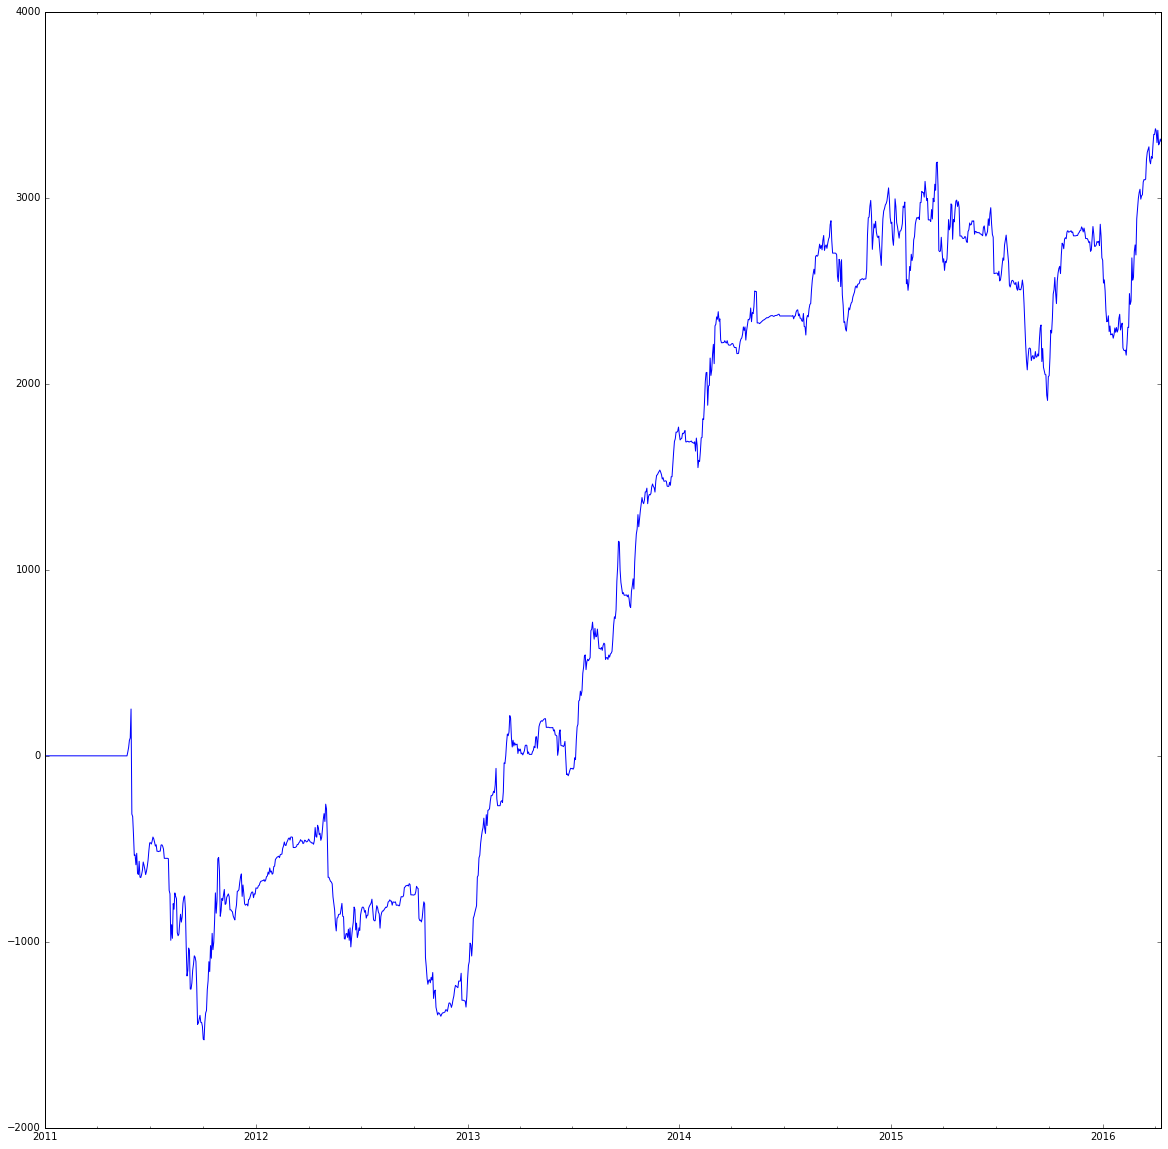

In [422]:
avg_swarm.plot()